# Qualitative Evaluation on self-trained embeddings

In [1]:
import argparse
import time
import math
import torch
import torch.nn as nn
from torch.autograd import Variable
from scipy.spatial.distance import cdist
import data
import model
import matplotlib.pyplot as plt
import pylab
import numpy as np

In [2]:
!pwd

/Users/zhuorulin/Documents/DataScience/DS1003_Final_Project/lstm


In [3]:
corpus = data.Corpus('./data/brown')

In [4]:
corpus.dictionary.idx2word[0]

'<MASK>'

In [5]:
#Load trained embeddings
model_trained = torch.load('model_winSize4_cpu.pt')
emb_trained = model_trained.encoder
emb_np = emb_trained.cpu().weight.data.numpy()

/Users/zhuorulin/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:284: SourceChangeWarning: source code of class 'model.RNNModel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [ ]:
#TSNE Ploting
from sklearn.manifold import TSNE
TSNE_model = TSNE(n_components=2,random_state=0)

#Warning Long Training Process
representations2D = TSNE_model.fit_transform(emb_np)

In [ ]:
# plt.figure(figsize=(10,10))
# plt.scatter(representations2D[:,0],representations2D[:,1],s=0.1)
# #for word_idx,word in enumerate(words_to_plot):
# #    plt.annotate(word,representations2D[word_idx])
# #plt.xlim([-100,100])
# #plt.ylim([-100,100])
# plt.title('2D representation: Brown 512d')
# plt.show()

In [34]:
from sklearn.cluster import KMeans
kmeans_brown = KMeans(init='k-means++', n_clusters=80, n_init=10)
kmeans_brown.fit(representations2D)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=80, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [35]:
def clusterPlot2D(rep2D,kmeans,savepath = 'TSNE_Plot',title='T-SNE representations'):
    plt.figure(figsize=(20,20))
    pylab.scatter(rep2D[:,0],rep2D[:,1],s=2,c=kmeans.labels_,cmap=pylab.cm.Accent)
    pylab.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],c='r')
    bbox_props = dict(boxstyle="rarrow", fc="cyan",pad=0.001, ec="b", lw=0.1)
    for center_idx,center in enumerate(kmeans.cluster_centers_):
        pylab.annotate(center_idx,center,bbox=bbox_props,rotation=45,va='top',ha='right')
    #for word_idx,word in enumerate(words_to_plot):
    #    plt.annotate(word,representations2D[word_idx])
    plt.title(title)
    plt.savefig('%s.png'%(savepath))
    plt.show()

def zoom(rep2D,kmeans,corpus,index_to_zoom,closest = 100):
    cluster_index = kmeans.labels_
    cluster_centers = kmeans.cluster_centers_
    plt.figure(figsize=(10,10))
    specified_pos = np.where(cluster_index==index_to_zoom)[0]
    rep2D_to_plot = rep2D[specified_pos]
    #calculate the distances between each word and its cluster center
    center = cluster_centers[index_to_zoom]
    dist2ctr = cdist(center.reshape(-1,2),rep2D_to_plot.reshape(-1,2),'euclidean')[0]
    #Sort by Euclidean Dist
    mat = np.zeros(len(dist2ctr)*4).reshape(len(dist2ctr),4)
    mat[:,:2] = rep2D_to_plot
    mat[:,2] = dist2ctr 
    mat[:,3] = specified_pos
    sorted_mat = np.array(sorted(mat,key=lambda x:x[2]))
    first_N_rep = sorted_mat[:closest,:2]
    first_N_idx = [int(x) for x in sorted_mat[:closest,3]]
    words_to_annotate = [corpus.dictionary.idx2word[idx] for idx in first_N_idx]
    #pylab.scatter(rep2D_to_plot[:,0],rep2D_to_plot[:,1],s=2)
    pylab.scatter(first_N_rep[:,0],first_N_rep[:,1],s=2)
    pylab.scatter(cluster_centers[index_to_zoom][0],cluster_centers[index_to_zoom][1],c='r')
    for word_pos,coordinate in enumerate(first_N_rep):
        pylab.annotate(words_to_annotate[word_pos],coordinate)
    plt.show()
    return words_to_annotate
    

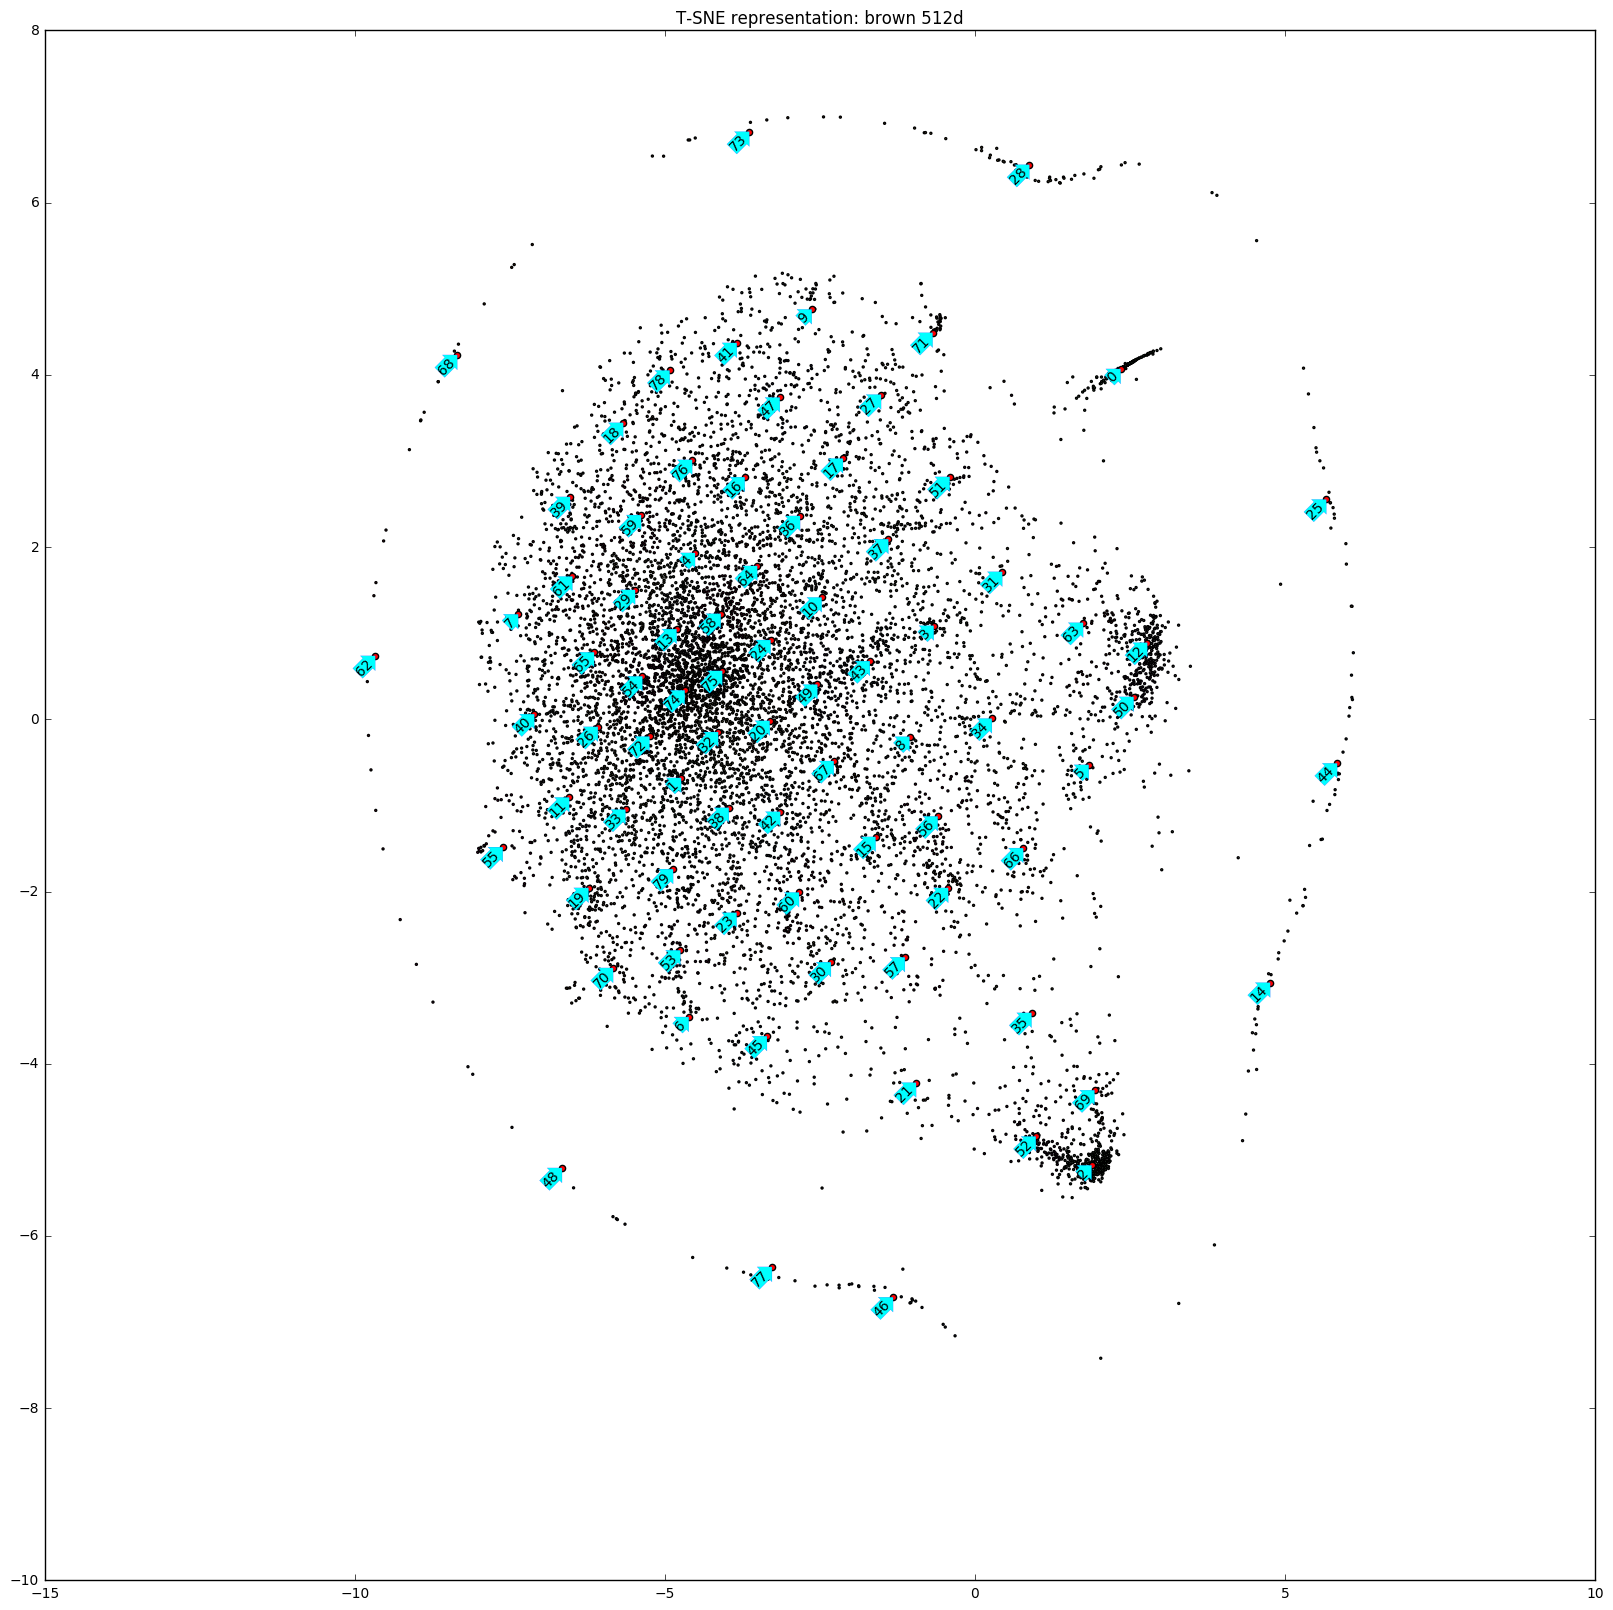

In [36]:
clusterPlot2D(representations2D,kmeans_brown\
              ,savepath='tsne.png',title='T-SNE representation: brown 512d')

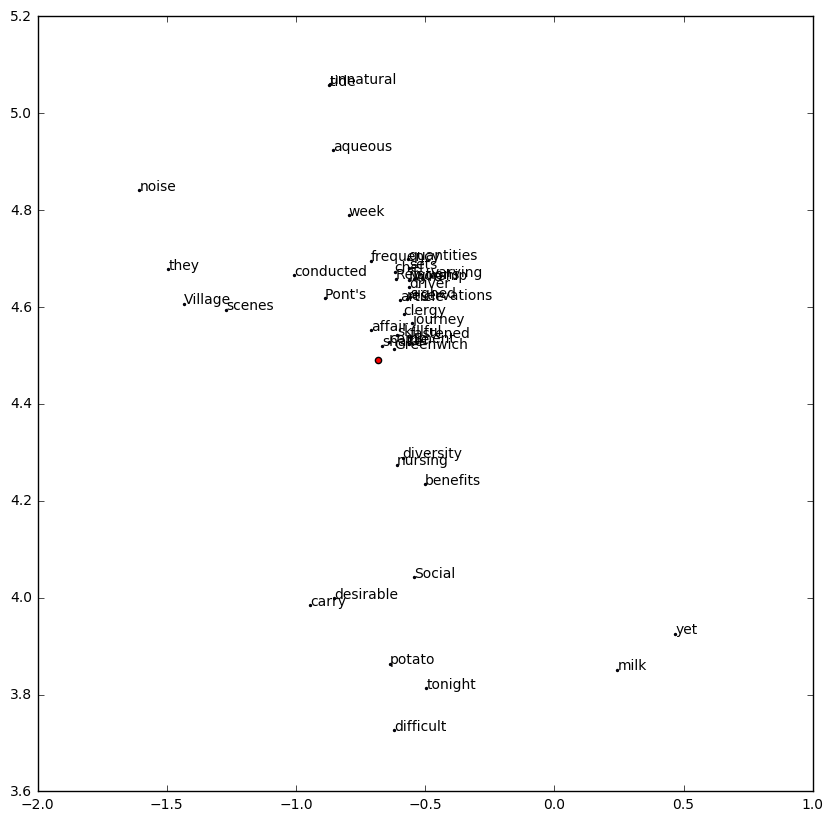

['shake', 'comment', 'Greenwich', 'affair', 'skillful', 'die', 'fastened', 'clergy', 'journey', 'article', 'reservations', 'sighed', 'Relations', 'driver', 'chef', 'Myra', 'frequency', 'worship', 'diversity', 'sets', 'nursing', 'quantities', "Pont's", 'varying', 'benefits', 'week', 'conducted', 'aqueous', 'Social', 'desirable', 'carry', 'tide', 'scenes', 'unnatural', 'potato', 'tonight', 'Village', 'difficult', 'they', 'noise', 'milk', 'yet']


In [41]:
print(zoom(representations2D,kmeans_brown,corpus,index_to_zoom=71,closest=100))

# Hold-out prediction sample

In [32]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [6]:
from nltk.corpus import semcor

In [7]:
example_sent = semcor.sents()[99:101]

In [8]:
example_sent = [item for sublist in example_sent for item in sublist]

In [9]:
' '.join(example_sent)

"Dewey Lawrence , a Tyler lawyer representing the Texas Bankers Association , sounded the opposition keynote when he said it would force banks to violate their contractual obligations with depositors and undermine the confidence of bank customers . `` If you destroy confidence in banks , you do something to the economy '' , he said ."

In [10]:
example_sent.index('violate')

24

In [12]:
context_eg = example_sent[24-4:24+4+1]
holdout = context_eg[4]
print('Context: %s'%(' '.join(context_eg)))
print('Holdout word: %s'%(holdout))

Context: would force banks to violate their contractual obligations with
Holdout word: violate


In [13]:
corpus.dictionary.word2idx['<UNK>']

5

In [20]:
indexlist = []
for word in context_eg:
    try:
        indexlist.append(corpus.dictionary.word2idx[word])
    except:
        indexlist.append(corpus.dictionary.word2idx['<UNK>'])
context_idx = Variable(torch.LongTensor(indexlist).view(-1,1))
context_idx[8] = corpus.dictionary.word2idx['<MASK>']

In [21]:
context_idx

Variable containing:
  361
  406
  775
   53
    5
  795
    5
  796
  182
[torch.LongTensor of size 9x1]

In [22]:
hidden = model_trained.init_hidden(1)

output,hidden = model_trained.forward(context_idx,hidden)

output_np = output.data.numpy()

best10 = sorted(output_np[0],reverse=True)[9]

In [23]:
best10

7.9514976

In [24]:
import numpy as np
predictions = np.where(output_np>=best10)[1]

In [25]:
[corpus.dictionary.idx2word[idx] for idx in predictions]

['Jan.',
 'if',
 'Without',
 'A.',
 'We',
 'patient',
 'aggression',
 'Kentucky',
 'traffic',
 'elect']

The Prediction base on context window of size 4 seems merely recognize the pos (Noun)